# XGBoost Classifier
## Librerias y parametros inciales

In [1]:
import lib.main_func_p1, lib.main_func_p2, lib.main_func_p3, lib.main_func_p4
from lib.main_func_p1 import timer, path
from lib.main_func_p4 import resampling_set

import numpy as np
import pandas as pd

# save the models
import pickle

from collections import OrderedDict
from importlib import reload

#XGBoost library
import xgboost as xgb

In [2]:
#####################################
# proteina (uniprot_ID)
uniprot_id = 'P56817'
path_file = path(uniprot_id)

# Parametros
seed = 142854
fp_name = 'morgan2_c'

## Carga datos

### Load external validation dataset

In [3]:
df_external_valid = pd.read_pickle(f'{path_file}_dataset_valid')
X_valid, y_valid = df_external_valid[fp_name].tolist(), df_external_valid['activity'].tolist()
print(f'>>> LOAD: {uniprot_id}_dataset_valid')
decoy_samples = min(list(df_external_valid.activity.value_counts()))

>>> LOAD: P56817_dataset_valid


### Carga y preparación de los decoys
El archivo {uniprot_id}_all_smiles.ism contiene la lista de decoys del target.
Se carga el archivo y se convierte en un data set, por ahora solo contiene el SMILE.
Se escoge aleatoriamente una muestra con la misma cantidad de compuestos activos / inactivos (1:1:1)
Se encuentra el fingerprint de cada decoy a partir del SMILE.

In [4]:
reload(lib.main_func_p3)
from lib.main_func_p3 import calculate_onefp

df_decoys = pd.DataFrame(columns=['smiles'])
list_d = list()
decoys_len = int(decoy_samples)
with open(f'data/_decoys/{uniprot_id}_all_smiles.ism', 'rb') as f:
    decoys_line = f.readlines()
    for line in decoys_line[1:]: #la primera linea es header
        line = line.decode('UTF-8').split()
        list_d.append(line)
df_decoys = pd.DataFrame(list_d, columns=['smiles', 'id'])

print(f'Decoys iniciales: {df_decoys.shape}')
# OPC 1: Escoger una cantidad igual al conjunto de prueba
df_decoys = df_decoys.sample(n=decoys_len, ignore_index=True)

# OPC 2: Trabajar con un porcentaje
# df_decoys = df_decoys.sample(frac=0.9, ignore_index=True, random_state=seed)

print(f'Decoys conjunto muestra: {len(df_decoys)}')
calculate_onefp(df_decoys, fp_name)
df_decoys.drop_duplicates(subset=['smiles'], inplace=True)
df_decoys.reset_index(inplace=True, drop=True)
df_decoys = df_decoys.drop(['mol'], axis=1)
df_decoys = df_decoys.drop(['smiles'], axis=1)
df_decoys['type'] = 'decoy'
df_decoys = df_decoys[['type', fp_name]]
df_decoys.head()

Decoys iniciales: (18100, 2)
Decoys conjunto muestra: 120


,type,morgan2_c
0,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."


## Carga modelo óptimo

In [5]:
# Instanciar el modelo
xgbc_tuned = xgb.XGBClassifier()
# Cargar el modelo
xgbc_tuned.load_model(f'./models/{uniprot_id}_model.ubj')
print(f'Parametros: \n{xgbc_tuned.get_params()}')

Parametros: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': 10, 'enable_categorical': False, 'eval_metric': ['error', 'auc'], 'gamma': 0.1, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.4, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 7, 'max_leaves': 0, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1.5, 'subsample': 0.9, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 0.7, 'lambda': 1.4}


## Construcción y verificación del modelo

In [6]:
reload(lib.main_func_p4)
from lib.main_func_p4 import model_clf

# XGBoost  model
# ya tiene por defecto el conjunto de entrenamiento
tick = timer()
xgbc_tuned, df_results_model_tuned, results_ROC_fp = model_clf(xgbc_tuned, fp_name, uniprot_id, seed=seed,
                                                               save_log=True)
tock = timer(tick)
df_results_model_tuned

Total=4847. 1.0(4168)/0.0(679). ratio=6.14
Results XGBClassifier: 
-------------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       102
         1.0       0.99      0.98      0.99       626

    accuracy                           0.98       728
   macro avg       0.95      0.97      0.96       728
weighted avg       0.98      0.98      0.98       728



,Train,Test
Metric,,
AUC,0.991,0.993
accuracy,0.97,0.978
recall_(sens),0.98,0.982
specificity,0.909,0.953
precision,0.986,0.992
f1_score,0.971,0.978
confusion_matrix,"[[527, 50], [72, 3470]]","[[97, 5], [11, 615]]"


### ROC curve

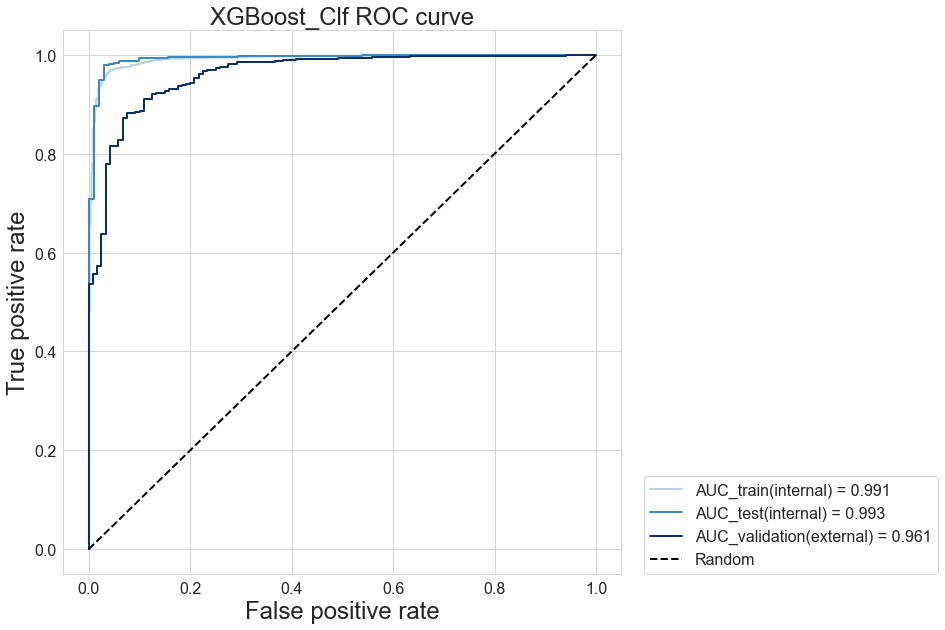

In [7]:
from lib.main_func_p4 import plot_ROC_curve
from sklearn.metrics import roc_curve, auc, classification_report

# Calcular probabilidades del conjunto de datos externo
pred_valid = xgbc_tuned.predict(X_valid)
df_external_valid['prediction'] = pred_valid

prediction_prob_valid = np.array(xgbc_tuned.predict_proba(X_valid)[:,1])
df_external_valid['prediction_prob'] = prediction_prob_valid

fpr_valid, tpr_valid, _ = roc_curve(y_valid, prediction_prob_valid)
auc_score_unseen = auc(fpr_valid, tpr_valid)
metrics_ROC_valid = (fpr_valid, tpr_valid, auc_score_unseen)

model_name = f'XGBoost_Clf'
metrics_ROC = results_ROC_fp.copy()
metrics_ROC.extend([metrics_ROC_valid])
metrics_ROC_name = ['train(internal)', 'test(internal)', 'validation(external)']

# print(classification_report(y_valid, pred_valid))
plot_ROC_curve(metrics_ROC, metrics_ROC_name, model_name, path_file=path_file, save_fig=True)

### Calibration curve
#### Train dataset

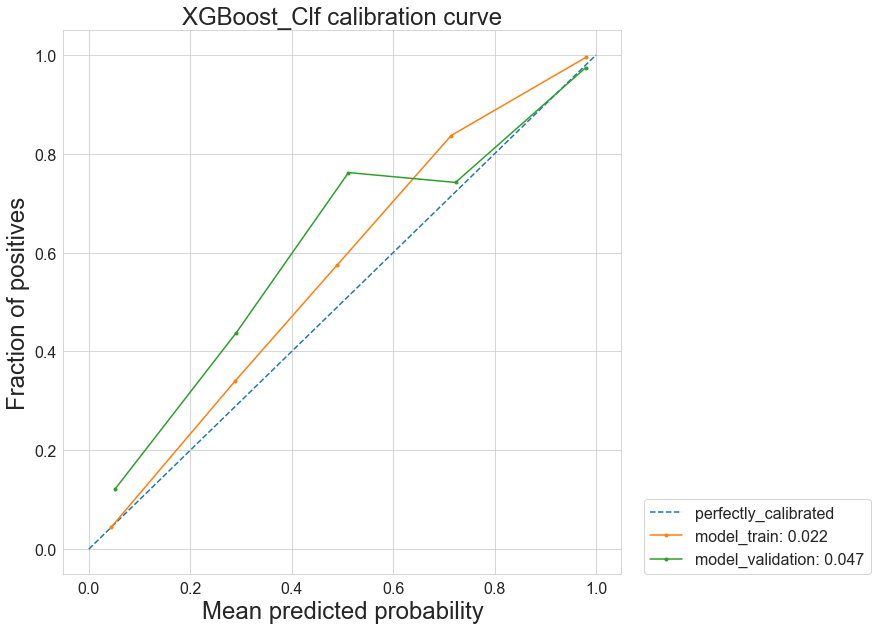

In [8]:
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve

df_internal = pd.read_pickle(f'{path_file}_dataset_train')
X_test, y_test = df_internal[fp_name].tolist(), df_internal['activity'].tolist()
# Calcular probabilidades del conjunto de datos interno
pred_test = xgbc_tuned.predict(X_test)
df_internal['prediction'] = pred_test

prediction_prob_test = np.array(xgbc_tuned.predict_proba(X_test)[:,1])
df_internal['prediction_prob'] = prediction_prob_test

model_name = f'XGBoost_Clf'
plots_list = [df_internal, df_external_valid]
plots_name_list = ['model_train', 'model_validation']

plot_calibration_curve(plots_list, plots_name_list, model_name, path_file=path_file, save_fig=True)

## Uso del modelo

In [9]:
print(f'Datos iniciales: {df_external_valid.shape}')

# Resample
df_valid_external_rsmpl = resampling_set(df_external_valid, mode='under_sampling', ratio=1)
print('Submuestreo')

df_valid_external_rsmpl['type'] = 'valid_inactive'
df_valid_external_rsmpl.loc[df_valid_external_rsmpl[df_valid_external_rsmpl.activity == 1.0].index, 'type'] = 'valid_active'
df_valid_external_rsmpl.reset_index(drop=True, inplace=True)
print(df_valid_external_rsmpl.shape)
print(df_valid_external_rsmpl.activity.value_counts())

df_valid_external_rsmpl = df_valid_external_rsmpl[['type', fp_name, 'activity', 'prediction', 'prediction_prob']]
df_valid_external_rsmpl.head()

Datos iniciales: (856, 5)
Submuestreo
(240, 6)
0.0    120
1.0    120
Name: activity, dtype: int64


,type,morgan2_c,activity,prediction,prediction_prob
0,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0,0,0.103206
1,valid_inactive,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.011398
2,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.955252
3,valid_active,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,1,0.998549
4,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.997314


In [10]:
df_valid_external_rsmpl

,type,morgan2_c,activity,prediction,prediction_prob
0,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0,0,0.103206
1,valid_inactive,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.011398
2,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.955252
3,valid_active,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,1,0.998549
4,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.997314
...,...,...,...,...,...
235,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.997741
236,valid_inactive,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",0.0,0,0.099075
237,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.375202
238,valid_active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.968808


### Predicciones

Con el modelo cargado, clasificar cada compuesto del conjunto decoys en activo: 1.0 o inactivo 0.0

In [11]:
x_decoy = df_decoys[fp_name].tolist()
pred_decoy = xgbc_tuned.predict(x_decoy)
prediction_prob = xgbc_tuned.predict_proba(x_decoy)[:,1]
prediction_prob = np.array(prediction_prob)
df_decoys['activity'] = 0.0
df_decoys['prediction'] = pred_decoy
df_decoys['prediction_prob'] = prediction_prob
df_decoys.head()

,type,morgan2_c,activity,prediction,prediction_prob
0,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.402754
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.379698
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.597154
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.095051
4,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",0.0,0,0.116092


In [12]:
df_decoys

,type,morgan2_c,activity,prediction,prediction_prob
0,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.402754
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.379698
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.597154
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.095051
4,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",0.0,0,0.116092
...,...,...,...,...,...
115,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1,0.805296
116,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.005137
117,decoy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.165953
118,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.009463


In [13]:
df_decoys.prediction.value_counts()

0    93
1    27
Name: prediction, dtype: int64

valid_inactive    120
valid_active      120
decoy             120
Name: type, dtype: int64


<Figure size 1080x1080 with 0 Axes>

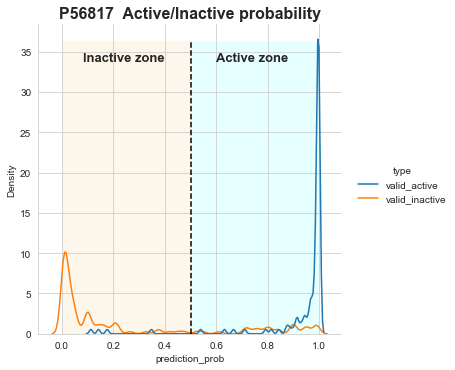

In [14]:
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_probability_curve

df = pd.concat([df_valid_external_rsmpl, df_decoys], ignore_index=True)
print(df.type.value_counts())

hue_order=['valid_active', 'valid_inactive']
plot_probability_curve(df, uniprot_id, hue_order=hue_order,
                       path_file=path_file, save_fig=True)

<Figure size 1080x1080 with 0 Axes>

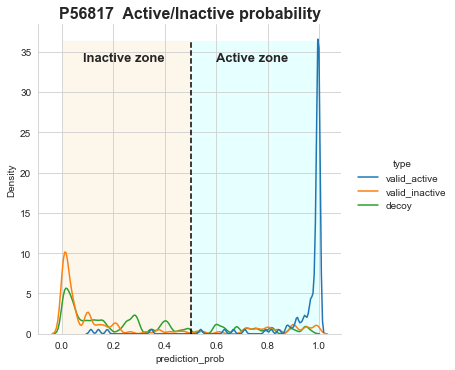

In [15]:
hue_order=['valid_active', 'valid_inactive', 'decoy']
plot_probability_curve(df, uniprot_id, hue_order=hue_order,
                       path_file=path_file, name_mod='(decoys)', save_fig=True)

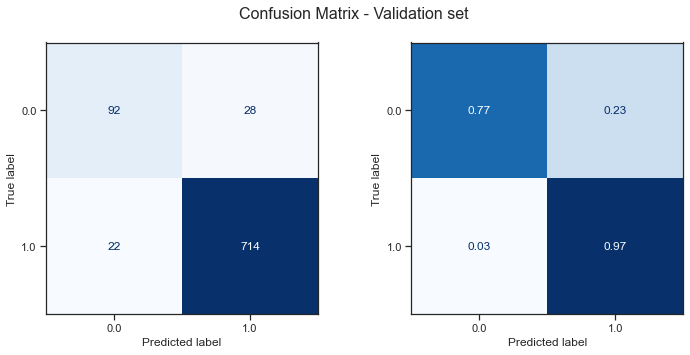

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Confusion Matrix - Validation set', size=16)
disp1 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid, y_valid,
                                              cmap=plt.cm.Blues, normalize=None,
                                              colorbar=False, ax=ax1)
disp2 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid, y_valid,
                                              cmap=plt.cm.Blues, normalize='true',
                                              colorbar=False, ax=ax2)
plt.savefig(f'{path_file}_IMG06_ConfusionMatrix.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()